## Breast Cancer Diagnosis

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_csv('../breast_cancer_data.txt',sep= ',')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We will drop out the first column `id` and move the target `diagnosis` to the last column, just for convenience.

In [4]:
df = df.drop('id', axis=1) # remove id column
df1 = df.pop('diagnosis') # remove column diagnosis and store it in df1
df['diagnosis'] = df1 # add df1 to df as a 'new' column

In [5]:
# convert B to -1, M to 1:
df.diagnosis = [0 if t == "B" else 1 for t in df.diagnosis]

In [6]:
# select features and target:
ds = np.array(df).astype(float)

# features:
X = ds[:,:-1]
l,n = X.shape
print(l,n)

# target:
y = ds[:,-1]
# convert 1,0 to 1,-1:
y = 2*y - 1

569 30


In [7]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

### Prediction

In [8]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=20,regu=0.001)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [9]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        #X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)
        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [10]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.96210526 0.93105263 0.95       0.97289474]
0.6 [0.95640351 0.93236842 0.94798246 0.97192982]
0.4 [0.9504386  0.93157895 0.94140351 0.97035088]
0.2 [0.93877193 0.93035088 0.93552632 0.96236842]


In [11]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,expectation_reflection
0,0.8,0.962105,0.931053,0.950000,0.972895
1,0.6,0.956404,0.932368,0.947982,0.971930
2,0.4,0.950439,0.931579,0.941404,0.970351
3,0.2,0.938772,0.930351,0.935526,0.962368


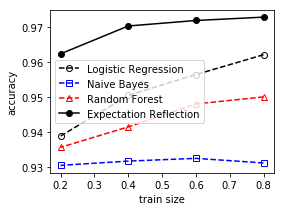

In [12]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
#plt.plot(list_train_size,acc[:,3],'b--',label='Decision Tree')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy')
plt.legend()

In [13]:
acc_std

array([[0.0185617 , 0.02431012, 0.02092432, 0.01376355],
       [0.01963247, 0.02318496, 0.02271422, 0.01478272],
       [0.02278592, 0.02440426, 0.02369655, 0.01508058],
       [0.02566385, 0.02430379, 0.02546505, 0.01742482]])

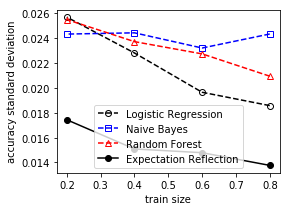

In [14]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()

In [15]:
np.savetxt('breastcancer_acc.txt',acc,fmt='%f')
np.savetxt('breastcancer_acc_std.txt',acc_std,fmt='%f')